### Experiment6.2
Author : @leopauly | cnlp@leeds.ac.uk <br>
Description : Studying the feature vectors in the feature space

In [1]:
import os
from six.moves import xrange  # pylint: disable=redefined-builtin
import PIL.Image as Image
import random
import numpy as np
import cv2
import time
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage import io
from sklearn import metrics
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as hcluster

# Custom scripts
import lscript as lsp
import modelling as md

Using TensorFlow backend.


In [2]:
height=112 
width=112 
channel=3
crop_size=112

cluster_length=16
feature_size=8192 #4608 #   #16384  #487
nb_classes=2
saved_path='/nobackup/leopauly/S2l/'

batch_size=32
memory_batch_size_train=266
memory_batch_size_test=170
next_batch_start=0
sample_batch_size=10

####  Loading model and functions for calculating distance

In [3]:
## Defining placeholders in tf for images and targets
x_image = tf.placeholder(tf.float32, [None, 16,height,width,channel],name='x') 
y_true = tf.placeholder(tf.float32, [None, nb_classes],name='y_true')
y_true_cls = tf.placeholder(tf.int64, [None],name='y_true_cls')

model_keras = md.C3D_ucf101_training_model_tf(summary=True)
out=model_keras(x_image)
y_pred = tf.nn.softmax(out)
y_pred_cls = tf.argmax(out, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print('Miscellenious items finished..!!',flush=True)

/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_RA-L/modelling.py:281: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, (3, 3, 3), activation="relu", name="conv1", input_shape=(16, 112, ..., padding="same")`
  input_shape=input_shape))
/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_RA-L/modelling.py:283: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name="pool1", padding="valid")`
  border_mode='valid', name='pool1'))
/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_RA-L/modelling.py:286: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(128, (3, 3, 3), activation="relu", name="conv2", padding="same")`
  border_mode='same', name='conv2'))
/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_RA-L/modelling.py:288: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_si

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 56, 56, 128)   221312    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 8, 28, 28, 128)    0         
_________________________________________________________________
conv3a (Conv3D)              (None, 8, 28, 28, 256)    884992    
_________________________________________________________________
conv3b (Conv3D)              (None, 8, 28, 28, 256)    1769728   
_________________________________________________________________
pool3 (MaxPooling3D)         (None, 4, 14, 14, 256)    0         
__________

In [4]:
def get_compress_frames_data(filename, num_frames_per_clip=16):
  ''' Given a directory containing extracted frames, return a video clip of
  (num_frames_per_clip) consecutive frames as a list of np arrays '''
  ret_arr = []
  for parent, dirnames, filenames in os.walk(filename):

    filenames = sorted(filenames)
    jump=math.floor((len(filenames)/num_frames_per_clip))
    loop=0
    for i in range(0,len(filenames),jump):
      if (loop>15):
        break
      if (filenames[i].endswith('.png')):
        #print(str(filename) + '/' + str(filenames[i]))
        image_name = str(filename) + '/' + str(filenames[i])
        img = Image.open(image_name)
        img_data = np.array(img)
        ret_arr.append(img_data)
        loop=loop+1
  ret_arr=np.array(ret_arr)
  #ret_arr=ret_arr/255
  return np.array(ret_arr)

In [5]:
## Extraction of features 
def extract_video_features(vid):
    vid_=vid.reshape(-1,cluster_length,height,width,channel)
    f_v = sess.graph.get_tensor_by_name('flatten_1/Reshape:0')  #('dropout_2/cond/Merge:0')  #
    f_v_val=sess.run([f_v], feed_dict={'conv1_input:0':vid_,x_image:vid_,K.learning_phase(): 0 })
    features=np.reshape(f_v_val,(-1))
    return features

####  Feature extraction and Plotting

In [6]:
## Start the session with logging placement.
init_op = tf.global_variables_initializer()
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
sess.run(init_op)

## Restore model weights from previously saved model
saver = tf.train.Saver()
saver.restore(sess, os.path.join(saved_path,'activity_model.ckpt-67'))
print("Model restored from file: %s" % saved_path,flush=True)

INFO:tensorflow:Restoring parameters from /nobackup/leopauly/S2l/activity_model.ckpt-67
Model restored from file: /nobackup/leopauly/S2l/


In [7]:
## Feature extraction

def get_features_from_class(class_folder):
    feature_set_a=[]
    base_dir_a=class_folder
    sub_dir_a=os.listdir(base_dir_a)
    sub_dir_a=sorted(sub_dir_a)
    print(sub_dir_a)
    if '.DS_Store' in sub_dir_a:
        sub_dir_a.remove('.DS_Store')
    for sub_dir_a_ in sub_dir_a:
        vid_a=get_compress_frames_data(base_dir_a+sub_dir_a_)
        feature_set_a.append(extract_video_features(vid_a))
    return np.array(feature_set_a)

In [8]:
feature_set_a=get_features_from_class('/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_ Only_tasks_CompvsIncomp/Push/')

['.DS_Store', 'push_demo_0deg', 'push_demo_180deg', 'push_demo_human', 'push_robo', 'push_robo_M2', 'push_robo_M3', 'push_robo_arbview1', 'push_robo_bg_fast', 'push_robo_change_pos', 'push_robo_changetarget', 'push_robo_fast', 'push_robo_green', 'push_robo_obj2_new', 'push_robo_sideview']


In [9]:
feature_set_b=get_features_from_class('/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_ Only_tasks_CompvsIncomp/Reach/')

['.DS_Store', 'reach_demo_0deg', 'reach_demo_180deg', 'reach_demo_green', 'reach_human', 'reach_robo', 'reach_robo_M2', 'reach_robo_M3', 'reach_robo_arbview1', 'reach_robo_bg', 'reach_robo_bg_change_target', 'reach_robo_change_pos', 'reach_robo_fast', 'reach_robo_obj2', 'reach_robo_sideview_new']


In [10]:
feature_set_c=get_features_from_class('/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_ Only_tasks_CompvsIncomp/Reach n Push/')

['.DS_Store', 'Multi_robo_M3', 'multi_demo_0deg', 'multi_demo_180deg', 'multi_robo', 'multi_robo_M2', 'multi_robo_arbview1', 'multi_robo_bg', 'multi_robo_change_pos', 'multi_robo_change_target', 'multi_robo_fast_new', 'multi_robo_human_new', 'multi_robo_obj', 'multi_robo_obj2', 'multi_robo_sideview']


In [11]:
feature_set_d=get_features_from_class('/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_ Only_tasks_CompvsIncomp/Incomplete/')

['.DS_Store', 'multi_robo_incomp', 'multi_robo_left', 'multi_robo_misc', 'multi_robo_out', 'multi_robo_right', 'push_robo_incomp', 'push_robo_left', 'push_robo_misc', 'push_robo_out_new', 'push_robo_right', 'reach_robo_after_target', 'reach_robo_incomp', 'reach_robo_left', 'reach_robo_out', 'reach_robo_right']


In [12]:
## TSNE compression
tsne_obj = PCA(n_components=3)

vis_tsne_a=tsne_obj.fit_transform(feature_set_a) 
vis_tsne_a=np.array(vis_tsne_a)

vis_tsne_b=tsne_obj.fit_transform(feature_set_b) 
vis_tsne_b=np.array(vis_tsne_b)

vis_tsne_c=tsne_obj.fit_transform(feature_set_c) 
vis_tsne_c=np.array(vis_tsne_c)

vis_tsne_d=tsne_obj.fit_transform(feature_set_d) 
vis_tsne_d=np.array(vis_tsne_d)

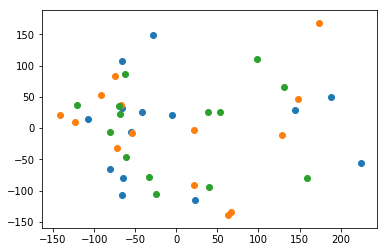

In [13]:
## Plotting
plt.scatter(vis_tsne_a[:, 0], vis_tsne_a[:, 1])
plt.scatter(vis_tsne_b[:, 0], vis_tsne_b[:, 1])
plt.scatter(vis_tsne_c[:, 0], vis_tsne_c[:, 1])

plt.show()

#### Clustering - Supervised

Number of clusters from unsupervised clustering: 6


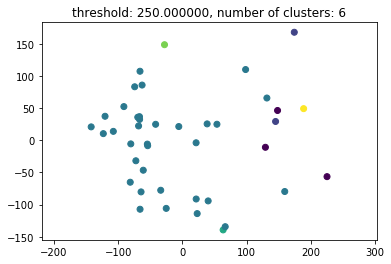

In [49]:
thresh = 250
data=np.concatenate((feature_set_a,feature_set_b,feature_set_c),axis=0)
clusters_unsupervised = hcluster.fclusterdata(data, thresh, criterion="distance")
print('Number of clusters from unsupervised clustering:', len(set(clusters_unsupervised)))

points_2d=np.concatenate((vis_tsne_a,vis_tsne_b,vis_tsne_c),axis=0)
plt.scatter(points_2d[:, 0], points_2d[:, 1], c=[clusters_unsupervised])
plt.axis("equal")
title = "threshold: %f, number of clusters: %d" % (thresh, len(set(clusters_unsupervised)))
plt.title(title)
plt.show()

#### Clustering - Supervised

In [ ]:
kmeans = KMeans(n_clusters=3)
points=np.concatenate((feature_set_a,feature_set_b,feature_set_c),axis=0)
kmeans.fit(points)
y_km = kmeans.fit_predict(points)

In [ ]:
print(y_km[0:14])
print(y_km[14:28])
print(y_km[28:42])

In [ ]:
## Accuracy for our method
y_true=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2]
print('Adjusted random score:',metrics.adjusted_rand_score(y_true,y_km))
print('Adjusted mutual infromation score:',metrics.adjusted_mutual_info_score(y_true,y_km))
print('Homogeneity score:',metrics.homogeneity_score(y_true,y_km))

In [ ]:
## Accuracy
import random
y_rand_label=np.random.randint(0,3,42)
print(y_rand_label)
print('Adjusted random score:',metrics.adjusted_rand_score(y_rand_label,y_km))
print('Adjusted mutual infromation score:',metrics.adjusted_mutual_info_score(y_rand_label,y_km))
print('Homogeneity score:',metrics.homogeneity_score(y_rand_label,y_km))

In [ ]:
points_2d=np.concatenate((vis_tsne_a,vis_tsne_b,vis_tsne_c),axis=0)
plt.scatter(points_2d[:, 0], points_2d[:, 1], c=y_km, s=50, cmap='viridis')
#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.show()